In [1]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import math

#### Load Data

In [2]:
from pathlib import Path

data_dirs = [Path("./"), Path("../")]

tf = transforms.Compose([
    # 0.1307 is the mean of the MNIST dataset, 0.3081 is the standard deviation
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), 
])

for data_dir in data_dirs:
    if (data_dir / "MNIST").exists():
        raw_train_data = datasets.MNIST(data_dir, train=True, transform=tf)
        raw_test_data = datasets.MNIST(data_dir, train=False, transform=tf)
        break
else:
    raw_train_data = datasets.MNIST("./", train=True, download=True, transform=tf)
    raw_test_data = datasets.MNIST("./", train=False, download=True, transform=tf)
    

g = torch.Generator().manual_seed(42)

### Patch


In [3]:
def patch(x: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    divide image into non-overlapping patches
    (B, C, H, W) -> (B, N, P*P*C) where N = (H/P)*(W/P)
    note: H and W must be divisible by P
    """
    # if x.size(-1) % patch_size != 0 or x.size(-2) % patch_size != 0:
    #     raise ValueError("Height and Width must be divisible by patch_size")
    N = (x.size(-2)//patch_size) * (x.size(-1) // patch_size)
    x = x.unfold(2, patch_size,patch_size).unfold(3, patch_size,patch_size)  # (B, C, H/P, W/P, P, P)
    x = x.permute(0, 2, 3, 1, 4, 5)  # (B, H/P, W/P, C, P, P)

    return x.reshape(x.size(0), N, -1)

In [4]:
def shifted_patch(x: torch.Tensor, patch_size: int):
    """
    Concat shifted images feature -> Patch features -> Patch flattening
    (B, C, H, W) -> (B, N, P*P*C*5)
    """
    # Shifting and concat
    # (B, C, H, W) -> (B, C, H, W, 5)
    p = patch_size / 2
    translates = [[0, 0], [p, p],[p,-p],[-p,-p],[-p,p]]
    shifted = torch.stack(
        [ v2.functional.affine(x, 0, translate, 1, [0.0], 0) for translate in translates ],
        dim = 1
    )

    # Patch Features & flattening
    N = (shifted.size(-2)//patch_size) * (shifted.size(-1) // patch_size)

    # (B, 5, C, H, W) -> (B, N, P*P*C*5)
    x = shifted.unfold(3,patch_size,patch_size).unfold(4,patch_size,patch_size) # (B, 5, C, H/P, W/P, P, P)
    x = x.permute(0, 3, 4, 1, 2, 5, 6) # (B, H/P, W/P, 5, C, P, P)

    return x.reshape(x.size(0), N, -1)

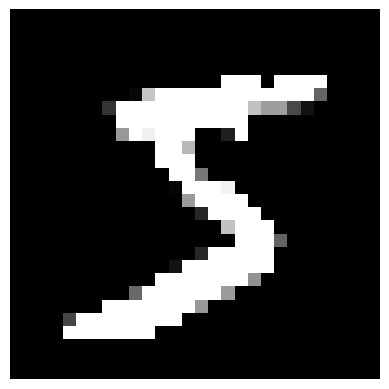

<Figure size 640x480 with 0 Axes>

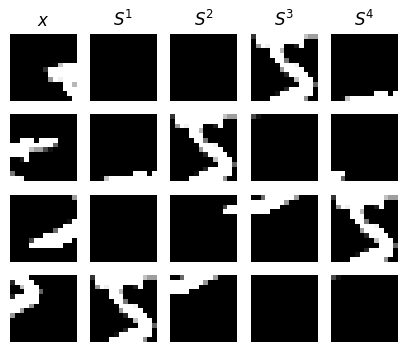

In [5]:
def test_shift_patch():
    inp = raw_train_data[0][0]
    plt.imshow(inp.squeeze(0), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")

    p = 14
    class monk:
        patch_size = p
    out = shifted_patch(inp.unsqueeze(0), p)
    
    N = out.size(1)
    fig = plt.figure()
    C = 1

    out = out.reshape(N, 5, C, p, p)

    fig = plt.figure(figsize=(5, N))
    for i in range(N):
        for j in range(5):
            ax = fig.add_subplot(N, 5, i * 5 + j + 1)
            if i == 0:
                ax.set_title(("$x$","$S^1$","$S^2$","$S^3$","$S^4$")[j])
            ax.axis("off")
            ax.imshow(out[i, j, 0], cmap="gray", vmin=0, vmax=1)

test_shift_patch()

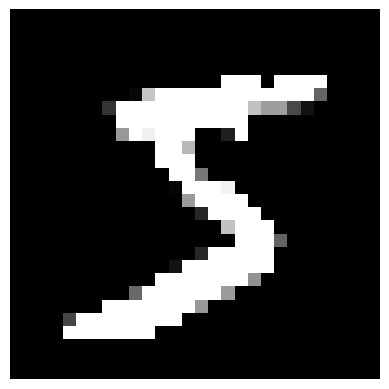

<Figure size 640x480 with 0 Axes>

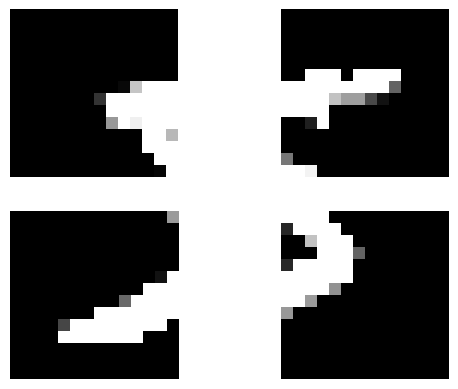

In [6]:
def test_patch():
    inp = raw_train_data[0][0]

    plt.imshow(inp.squeeze(0), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")

    p = 14
    out = patch(inp.unsqueeze(0), p)

    N = out.size(1)
    fig = plt.figure()
    C = 1
    out = out.reshape(N, C, p, p)

    fig = plt.figure()
    for i in range(N):
        ax = fig.add_subplot(int(N ** (1/2)), int(N ** (1/2)), i+1)
        ax.axis("off")
        ax.imshow(out[i,0], cmap="gray", vmin=0, vmax=1)

test_patch()

### Tokenization

In [7]:
class Tokenization(nn.Module):
    def __init__(self, patch_dim, emb_dim):
        """
        Tokenization and add CLS token
        (B, N, P*P*C) -> (B, N+1, d)
        patch_dim = P*P*C
        """
        super().__init__()
        self.projection = nn.Linear(patch_dim, emb_dim)
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_dim))
        self.pos_emb = nn.Parameter(torch.randn(1, 1, emb_dim))

    def forward(self, x:torch.Tensor):
        x = self.projection(x) # (B, N, d)
        cls_token = self.cls_token.expand(x.size(0), -1, -1) # (B, 1, d)
        pos_emb = self.pos_emb.expand(x.size(0), x.size(1) + 1, -1)
        return torch.cat((cls_token, x), dim = 1) + pos_emb

### Shifted Patch Tokenization

In [8]:
class SPT(nn.Module):
    """
    Shifted Patch Tokenization
    """
    def __init__(self, patch_size, emb_dim):
        """
        (B, N, P*P*C*5) -> (B, N+1, d)
        patch_dim = P*P*C*5
        """

        super().__init__()
        self.patch_size = patch_size
        patch_dim = patch_size * patch_size * 1 * 5

        self.norm = nn.LayerNorm(patch_dim)
        self.projection = nn.Linear(patch_dim, emb_dim)
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_dim))
        self.pos_emb = nn.Parameter(torch.randn(1, 1, emb_dim))

    def forward(self, x:torch.Tensor):
        x = shifted_patch(x, self.patch_size)
        x = self.projection(self.norm(x)) # (B, N, d)

        # Embedding Layer
        cls_token = self.cls_token.expand(x.size(0), -1, -1) # (B, 1, d)
        pos_emb = self.pos_emb.expand(x.size(0), x.size(1) + 1, -1)
        x = torch.cat((cls_token, x), dim = 1) + pos_emb
        
        return x
        # Pooling Layer
        # (B, N+1, d) -> ((B, N, d) ; (B, 1, d)) -> ((B, H/P, W/P, d); (B, ,, d))


### Attention

In [9]:
class SelfAttention(nn.Module):
    """
    (B, N+1, d) -> (B, N+1, d_v)
    d_q = d_k = d_v = d here
    note: d_q must equal to d_k in self-attention
    """
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.Q = nn.Linear(emb_dim, emb_dim)
        self.K = nn.Linear(emb_dim, emb_dim)
        self.V = nn.Linear(emb_dim, emb_dim)
    
    def forward(self, x:torch.Tensor):
        R = self.Q(x) @ self.K(x).transpose(-1, -2)
        # (B, N+1, d) @ (B, d, N+1) -> (... N+1, N+1)
        #      Q             K               Q    K
        SA = (
            F.softmax(R / math.sqrt(self.emb_dim), -1) # soft max on K
            @ self.V(x))
        return SA

### Transformer

In [10]:
class Transformer(nn.Module):
    def __init__(self, emb_dim, dropout_p = 0.0):
        super().__init__()
        self.attention = nn.MultiheadAttention(emb_dim, 4, batch_first=True, dropout=dropout_p)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*2),
            nn.GELU(),
            nn.Dropout(dropout_p),
            nn.Linear(emb_dim*2, emb_dim),
            nn.Dropout(dropout_p)
        )
    
    def forward(self, x):
        x = self.norm1(x)
        x = x + self.attention(x, x, x, need_weights=False)[0] # get output only
        return x + self.mlp(self.norm2(x))

In [11]:
class LSA(nn.Module):
    """
    Locality Self-Attention (Multi-head)
    (B, N+1, d) -> (B, N+1, d_v)
    d_q = d_k = d_v = d here
    note: d_q must equal to d_k in self-attention
    """
    def __init__(self, emb_dim, num_heads, dropout = 0.0):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.Q = nn.Linear(emb_dim, emb_dim)
        self.K = nn.Linear(emb_dim, emb_dim)
        self.V = nn.Linear(emb_dim, emb_dim)
        self.head_dim = emb_dim // num_heads
        self.t = nn.Parameter(torch.tensor(self.head_dim ** (1/2))) # learnable temperature
        self.proj = nn.Linear(emb_dim, emb_dim)
        self.atten_drop = nn.Dropout(dropout)
        self.proj_drop = nn.Dropout(dropout)
    
    def forward(self, x:torch.Tensor):
        # (B, N, d) -> (B, N, num_heads, head_dim) -> (B, num_heads, N, head_dim)
        head_dim = self.head_dim
        B, N, _ = x.size()
        q = self.Q(x).reshape(B, N, self.num_heads, head_dim).transpose(1, 2)
        k = self.K(x).reshape(B, N, self.num_heads, head_dim).transpose(1, 2)
        v = self.V(x).reshape(B, N, self.num_heads, head_dim).transpose(1, 2)

        # R: (B, num_heads, N+1, N+1)
        R = (q @ k.transpose(-1, -2)) / self.t
        # Diagonal Masking
        R.diagonal(2, 3).fill_(float("-inf"))

        # atten_heads: (B, num_heads, N+1, head_dim)
        atten_heads = (
            F.softmax(R, dim = -1) # soft max on K
            @ v)
        atten_heads = self.atten_drop(atten_heads)

        # (B, num_heads, N+1, head_dim) -> (B, N+1, emb_dim)
        atten_heads = atten_heads.transpose(1, 2).reshape(B, N, self.emb_dim)
        out = self.proj(atten_heads)
        out = self.proj_drop(out)
        return out # combine heads by projection

In [12]:
class LSATransformer(nn.Module):
    def __init__(self, emb_dim, dropout_p = 0.0):
        super().__init__()
        self.attention = LSA(emb_dim, 4, dropout = dropout_p)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*2),
            nn.GELU(),
            nn.Dropout(dropout_p),
            nn.Linear(emb_dim*2, emb_dim),
            nn.Dropout(dropout_p)
        )
    
    def forward(self, x):
        x = self.norm1(x)
        x = x + self.attention(x)
        return x + self.mlp(self.norm2(x))

In [13]:
# ref: https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html#using-nn-sequential
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

## Model

In [14]:
class ViT(nn.Module):
    def __init__(self, patch_size, d_model):
        super().__init__()
        self.model = nn.Sequential(
            # Lambda(lambda x: patch(x, patch_size)),
            # Tokenization(patch_size**2, d_model), # C == 1 in MNIST
            SPT(patch_size, d_model),
            Transformer(d_model, 0.6),
            Transformer(d_model, 0.6),
            Transformer(d_model, 0.6),
            Transformer(d_model, 0.6),
            # Head
            Lambda(lambda x: x[:,0,:]),
            nn.Linear(d_model, 10)
        )
        
    def forward(self, x):
        return self.model(x)
    

class SL_ViT(nn.Module):
    def __init__(self, patch_size, d_model):
        super().__init__()
        self.model = nn.Sequential(
            Lambda(lambda x: patch(x, patch_size)),
            Tokenization(patch_size**2, d_model), # C == 1 in MNIST
            # SPT(patch_size, d_model),
            LSATransformer(d_model, 0.6),
            LSATransformer(d_model, 0.6),
            LSATransformer(d_model, 0.6),
            LSATransformer(d_model, 0.6),
            # Head
            Lambda(lambda x: x[:,0,:]),
            nn.Linear(d_model, 10)
        )
        
    def forward(self, x):
        return self.model(x)

## Train

In [15]:
from train_runner import TrainRunner
runner = TrainRunner(raw_train_data, Path("./run/experiment4"))
# runner.quick_validation(model)

In [ ]:
model = SL_ViT(
    patch_size = 14,
    d_model = 256
)
runner.train(model, lr=0.03, bs=32, epochs=60, name="baseline")

In [ ]:
model = ViT(
    patch_size = 14,
    d_model = 64
)
runner.train(model, lr=0.03, bs=32, epochs=60, name="baseline")

# model = ViT(
#     patch_size = 28,
#     d_model = 64
# )
# runner.train(model, lr=0.03, bs=32, epochs=60, name="ps_28")


model = ViT(
    patch_size = 7,
    d_model = 64
)
runner.train(model, lr=0.03, bs=32, epochs=60, name="ps_7")

# model = ViT(
#     patch_size = 4,
#     d_model = 64
# )
# runner.train(model, lr=0.03, bs=32, epochs=60, name="ps_4")


model = ViT(
    patch_size = 14,
    d_model = 256
)
runner.train(model, lr=0.03, bs=32, epochs=60, name="d_256")

model = ViT(
    patch_size = 14,
    d_model = 128
)
runner.train(model, lr=0.03, bs=32, epochs=60, name="d_128")

model = ViT(
    patch_size = 14,
    d_model = 32
)
runner.train(model, lr=0.03, bs=32, epochs=60, name="d_32")

Save & Test

### Experiment 1
- baseline
    - Architecture:
        - Patch Embedding
        - Transformer block x4
            - MHSA, `num_head = 4`
            - MLP
                1. `Linear(emb_dim, emb_dim*2)`,
                2. `GELU`,
                3. `Linear(emb_dim*2, emb_dim)`
        - MLP Head

    - Hyper Parameters:
        - `patch_size = 14`
        - `d_model = 64`
        - `batch_size = 64`
        - `dropout_p = 0.6`
        - `leaning_rate = 0.03`
    
- different `batch_size` (**64**, 32, 16, 8) 
  <div align="left">
    <img src="./results/experiment1/1_1.png" width="45%">
    <img src="./results/experiment1/1_2.png" width="45%">
  </div>

  - 32, 16, 8 準確率相近，並且都比 64 高且穩定
  - 選擇 32 作為後續實驗的 batch_size

- different `patch_size` (**14**, 28, 7, 4) 
  <div align="left">
    <img src="./results/experiment1/2_1.png" width="45%">
    <img src="./results/experiment1/2_2.png" width="45%">
  </div>

    - 14 準確率較 28 高，耗時也比較短
    - 7、4 欠擬合

- different `d_model` (**64**, 32, 128) 
  <div align="left">
    <img src="./results/experiment1/3_1.png" width="45%">
  </div>

  - 128 效果最好
    
- Conclusion:
  - `batch_size = 32` 準確率最佳
  - `patch_size = 14` 準確率最佳
  - `d_model` 和準確率成正相關

### Experiment 2
- baseline
  - `batch_size = 32`
  - 其餘同 Experiment 1

- different `d_model` (**64**, 32, 128, 256) 
  - 左圖: acc (val), 右圖: loss (train & val)
  <div align="left">
    <img src="./results/experiment2/1_1.png" width="45%">
    <img src="./results/experiment2/1_2.png" width="45%">
  </div>

  - 256 最佳，但在 epoch 40 開始過擬合


- different `patch_size` (**14**, 28, 7, 4) 
  - 左圖: acc (val), 右圖: loss (train)
  <div align="left">
    <img src="./results/experiment2/2_1.png" width="45%">
    <img src="./results/experiment2/2_2.png" width="45%">
  </div>

  - 14 依然優於 28
  - 7，4 欠擬合 

- Conclusion:
  - `patch_size = 14` 準確率最佳
  - `d_model = 256` 準確率最佳，但有過擬合風險

### Experiment 3
比較將 Patch Embedding 換成 *Shifted Patch Tokenization* 的效果

Shifted Patch Tokenization (SPT) 來自論文 [Vision Transformer for Small-Size Datasets](https://arxiv.org/abs/2112.13492)

- `patch_size = 7` SPT 提升效果明顯:

  | `d_model` | Acc (Normal) | Acc (SPT) | Improvement |
  |------------|------------------|----------------|--------------|
  | 64 | 0.9503           | 0.9746         |   0.0243   |
  - 推測是 SPT 補充了小 patch size 不足的空間資訊

- `patch_size = 14` 表現均下降

  | `d_model` | Acc (Normal) | Acc (SPT) | Improvement |
  |------------|------------------|----------------|--------------|
  | 32 | 0.9756           | 0.9712         | -0.0044      |
  | 64       | 0.9792           | 0.9756         | -0.0036      |
  | 128      | 0.9827           | 0.9763         | -0.0064      |
  | 256      | 0.9837           | 0.9799         | -0.0038      |

  - d_model = 32, 64, 256 :
    過擬合

  - d_model = 128:
    訓練不佳
  
  - 深色線: loss (train)
    淺色線: loss (val)
    <div align="left">
      <img src="./results/experiment3/1_1.png" width="45%">
      <img src="./results/experiment3/1_2.png" width="45%">
      <img src="./results/experiment3/1_3.png" width="45%">
      <img src="./results/experiment3/1_4.png" width="45%">
    </div>